# Regridding runoff data to new grid

Many fields in MOM6 can be interpolated in runtime (e.g. tracer initial conditions).
but that doesnt work with runoff. These sources have to be located right at the coast.
Alistair Adcroft has a [package](https://github.com/adcroft/regrid_runoff) to regrid runoff conservatively.

First I will try to regrid the files for the 1/8 setup from Xiao

## Checks
- no negative values in conc
- are the nutrients all located along the coast, or do we have 
- do regridding for different res and see if the total flux of e.g. no3 flux is conserved.

# Some quality control on our current input files
The runoff and runoff concentrations are not interpolated in runtime. Hence the model will just assign the appropriate index of the array. This might lead to problems, particularly in the NH, when the original data is on a regular lat-lon grid instead of the model grid. 

In [2]:
import cartopy.crs as ccrs

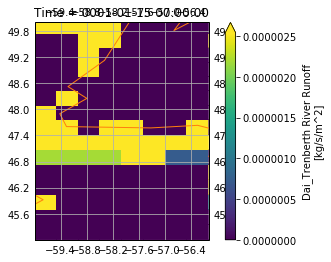

In [3]:
# First check the river runoff
path = '../data/raw/input_data/runoff.daitren.clim.v2011.02.10a.720x576.nc' # this is the file that is used raw in our low res run
ds = xr.open_dataset(path).isel(Time=0)
ax = plt.axes(projection=ccrs.PlateCarree())
ds.runoff.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)
ax.coastlines(color='C1')
ax.gridlines(draw_labels=True)
ax.set_extent([-60, -56, 45, 50])
# Still need to check the 

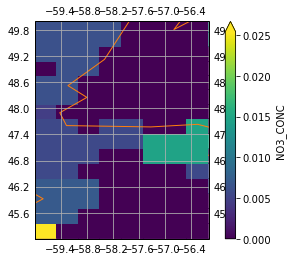

In [4]:
# First check the river runoff
path = '../data/raw/input_data/news_nutrients_halfdeg_20151207.nc'
ds = xr.open_dataset(path, drop_variables='time')#.isel(Time=0)
ds
ax = plt.axes(projection=ccrs.PlateCarree())
ds.NO3_CONC.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)
ax.coastlines(color='C1')
ax.gridlines(draw_labels=True)
ax.set_extent([-60, -56, 45, 50])
# Still need to check the 

Ok so the input for this model seems fine at first look. But it seems like the runoff is distributed not just along the coastline...

## How to regrid properly

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import xarray as xr
import os
import matplotlib.pyplot as plt
%matplotlib inline
from xarrayutils.utils import shift_lon

In [7]:
griddir = '../data/raw/grid_configs/xiao_0125/'
#
hgridpath = os.path.join(griddir, 'ocean_hgrid.nc')
hgrid = xr.open_dataset(hgridpath)
#
maskpath = os.path.join(griddir, 'ocean_mask.nc')
mask = xr.open_dataset(maskpath)

regrid_script = '../scripts/regrid_runoff/regrid_runoff.py'

In [100]:
# input data
# !!! There is a problem with this datafile. They have time both as dimension and coordinate. I had this problem previously.
# I should check with the xr folks if this is a CF conform case that needs to be supported...lets see for now if it works like this...
news_nutrients_025 = xr.open_dataset('../data/raw/input_data/news_nutrients_quarterdeg_20150918_v2.nc', drop_variables='time')
news_nutrients_025

news_nutrients_05 = xr.open_dataset('../data/raw/input_data/news_nutrients_halfdeg_20151207.nc', drop_variables='time')
news_nutrients_05

runoff_05 = xr.open_dataset('../data/raw/input_data/runoff.daitren.clim.v2011.02.10a.720x576.nc')
runoff_05

<xarray.Dataset>
Dimensions:   (Time: 12, grid_x_T: 720, grid_y_T: 576)
Coordinates:
  * Time      (Time) object 0001-01-15 00:00:00 ... 0001-12-16 00:00:00
  * grid_x_T  (grid_x_T) float64 -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
  * grid_y_T  (grid_y_T) float64 -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
Data variables:
    runoff    (Time, grid_y_T, grid_x_T) float64 ...
Attributes:
    history:  ../fre_nctools/tools/runoff_regrid/runoff_regrid_parallel --inp...

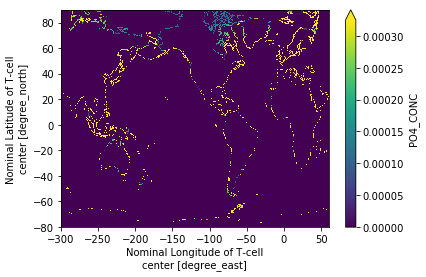

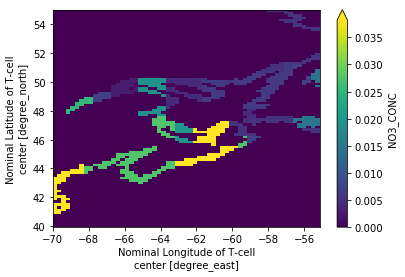

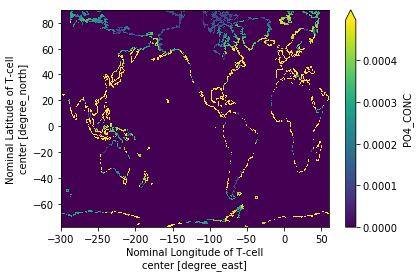

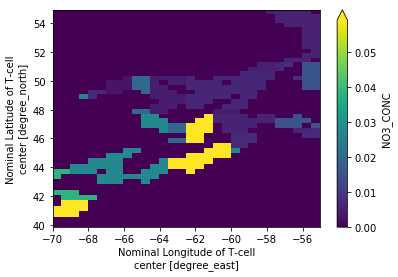

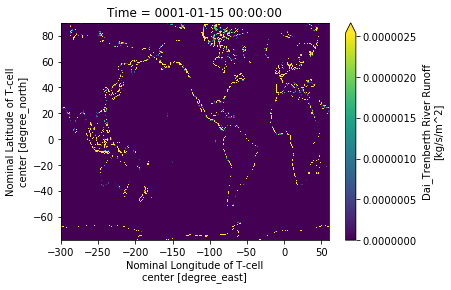

<Figure size 432x288 with 0 Axes>

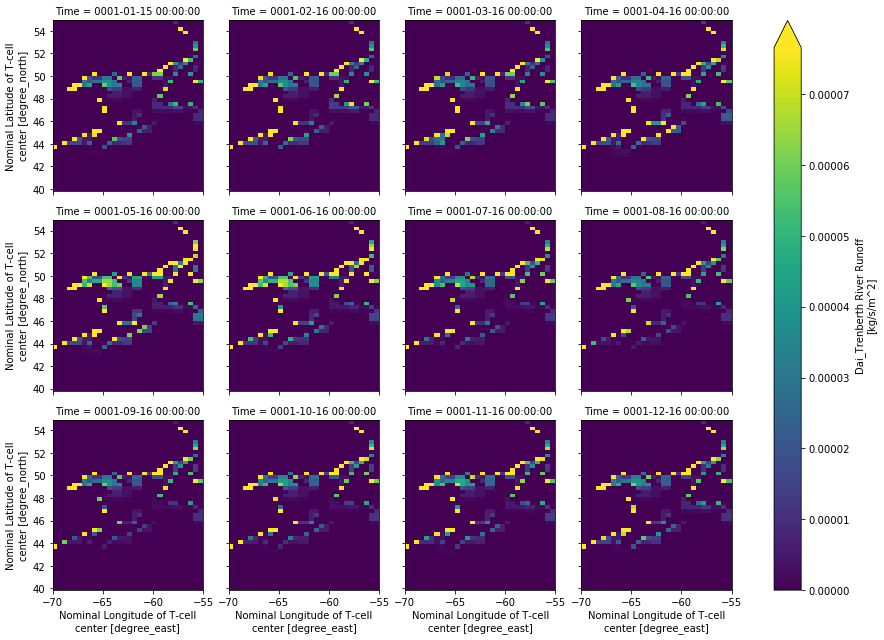

In [21]:
# initial check
roi = dict(grid_x_T=slice(-70, -55), grid_y_T=slice(40, 55))
datasets = [news_nutrients_025, news_nutrients_05]
for ds in datasets:
    plt.figure()
    ds.PO4_CONC.isel(time=0).plot(robust=True)
    
    plt.figure()
    ds.sel(**roi).NO3_CONC.squeeze().plot(robust=True)
    
plt.figure()
runoff_025.runoff.isel(Time=0).plot(robust=True)

plt.figure()
runoff_025.sel(**roi).runoff.squeeze().plot(robust=True, col='Time', col_wrap=4)

Ok this looks good. Now lets try to run the regridding. First lets see if we can call it from here:

We can pass notebook variables to the shellcommand by using this syntax `!echo {var}`

In [49]:
# !{regrid_script} -h

That looks good. Now lets define the inputs and outputs:

In [45]:
# inputfile = '../data/raw/input_data/runoff.daitren.clim.v2011.02.10a.720x576.nc' # this produces a `dimension mismatch` error
inputfile = '../data/raw/input_data/river_runoff_example.nc' # ill just take this...Ill hopefully get a new version soon anyways.
outfile = '../data/processed/runoff.daitren.clim.example.v2011.02.10a.2880x2240.nc'

In [46]:
!{regrid_script} {hgridpath} {maskpath} -p -m mask -r runoff {inputfile} {outfile}

Reading ocean grid ... done in 3.915s.
Ocean grid shape is 2240 x 2880.
Reading runoff grid ... done in 0.002s.
Runoff grid shape is 180 x 360.
Calculating river cell id for each ocean cell ... done in 0.222s.
Calculating number of ocean cell centers within each river cell ... done in 0.145s.
Frequency x river cells with # ocean cell centers:
1904x0 14x3 36x4 128x5 104x6 48x7 18x8 8x9 6x11 4x12 12x14 50x15 80x16 134x17 48x18 38x19 2x20 4x21 4x23 8x24 6x25 28x26 112x27 110x28 72x29 16x30 8x31 2x32 4x33 8x34 10x35 8x36 56x37 64x38 106x39 60x40 42x41 14x42 10x43 4x45 10x46 20x47 52x48 70x49 112x50 60x51 32x52 8x53 2x54 10x55 4x56 20x57 20x58 50x59 98x60 76x61 44x62 36x63 13332x64 10x65 20x66 42x68 42x69 50x70 80x71 9764x72 46x73 34x74 2x75 32x76 28x77 24x78 40x79 6528x80 44x81 40x82 24x83 58x84 44x85 26x86 46x87 3652x88 20x89 26x90 48x91 36x92 32x93 42x94 44x95 2950x96 56x97 42x98 58x99 22x100 22x101 26x102 36x103 2192x104 60x105 46x106 62x107 48x108 46x109 26x110 66x111 2916x112 30x113 4

In [54]:
xr.open_dataset('../data/raw/grid_configs/xiao_0125/topog.nc')

<xarray.Dataset>
Dimensions:        (nEdits: 1189, nx: 2880, ny: 2240)
Dimensions without coordinates: nEdits, nx, ny
Data variables:
    depth          (ny, nx) float32 ...
    wet            (ny, nx) float32 ...
    h2             (ny, nx) float32 ...
    modified_mask  (ny, nx) float32 ...
    iEdit          (nEdits) int32 ...
    jEdit          (nEdits) int32 ...
    zEdit          (nEdits) float32 ...

<xarray.DataArray 'runoff' ()>
array(False)
<xarray.DataArray 'runoff' ()>
array(False)


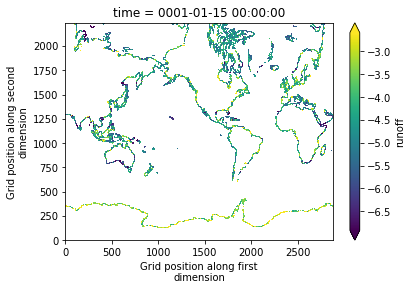

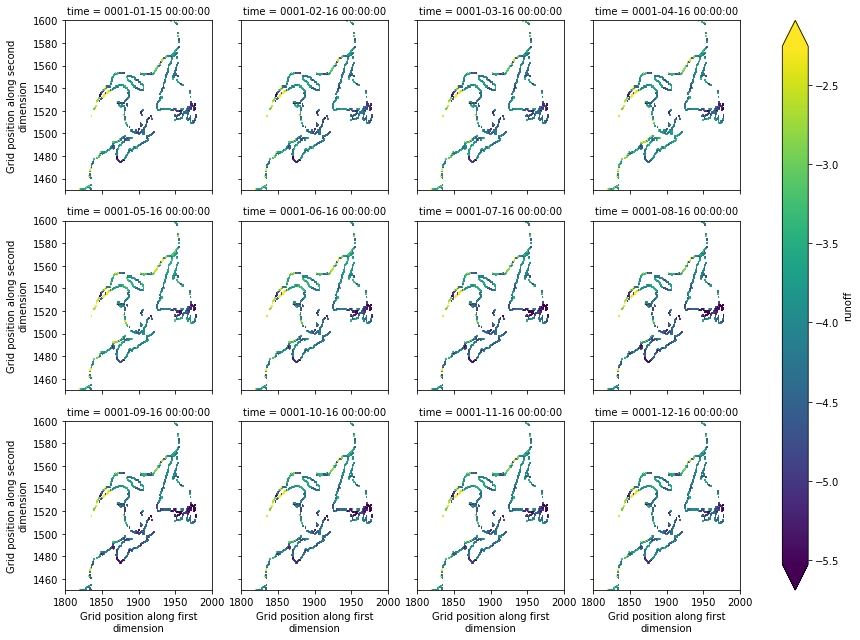

In [75]:
roi_0125 = dict(i=slice(1800,2000), j=slice(1450,1600))
vmax=-10

runoff_0125 = xr.open_dataset(outfile).fillna(0)
runoff_0125_plot = xr.ufuncs.log10(runoff_0125)

# check if any value is negative (should be false)
print((runoff_0125.runoff<0).any())
print((~xr.ufuncs.isfinite(runoff_0125.runoff)).any())

plt.figure()
runoff_0125_plot.runoff.isel(time=0).plot(robust=True)

# plt.figure()
runoff_0125_plot.sel(**roi_0125).runoff.squeeze().plot(robust=True, col='time', col_wrap=4)

In [107]:
integrated_runoff_0125 = (runoff_0125.runoff * runoff_0125.area).sum(['i', 'j'])
area_05 = xr.open_dataset('../data/raw/grid_configs/OM_05/ocean_static.nc').areacello.rename({'yh':'grid_y_T', 'xh':'grid_x_T'})
integrated_runoff_05 = (runoff_05.runoff * area_05).sum(['grid_y_T', 'grid_x_T'])

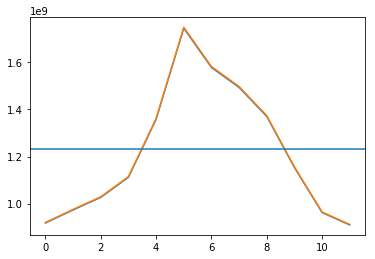

In [208]:
plt.plot(integrated_runoff_0125.data)
plt.plot(integrated_runoff_05)

# compare with news river database estimate (that fits well!)
plt.axhline(rivers['Discharge'].sum()*1000)

## River nutrients

Now we need to take care of the river tracers: I want to just interpolate them with nearest neighbor...and then stencil them out with the high res runoff file.

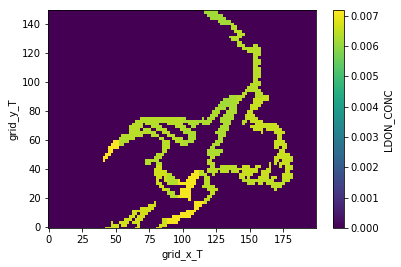

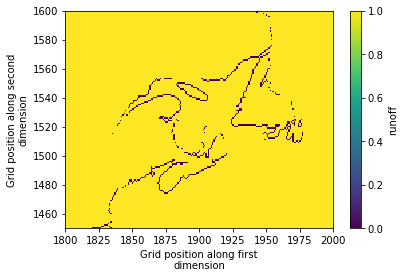

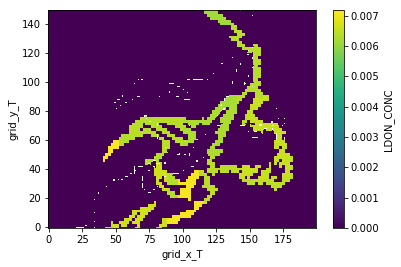

In [131]:
# This doesnt work...because the river nutrients get distorted
news_nutrients_0125 = news_nutrients_025.drop(['grid_x_T', 'grid_y_T'])
# remove zeroes and fill with nearest neighbor
# news_nutrients_0125 = news_nutrients_0125.where(news_nutrients_0125>0)
# news_nutrients_0125 = news_nutrients_0125.interpolate_na(dim=['grid_x_T', 'grid_y_T'],method='nearest')
news_nutrients_0125 = news_nutrients_0125.interp(grid_x_T=np.linspace(0,1440, 2880),
                                                 grid_y_T=np.linspace(0,1080, 2240), method='nearest')
roi_0125_mod = dict(grid_x_T=slice(1800,2000), grid_y_T=slice(1450,1600))

plt.figure()
news_nutrients_0125.LDON_CONC.isel(time=0).sel(**roi_0125_mod).plot()

plt.figure()
runoff_mask = (runoff_0125.runoff==0).all('time')
runoff_mask.sel(**roi_0125).plot()

plt.figure()
news_nutrients_0125.LDON_CONC.where(runoff_mask.data>0).isel(time=0).sel(**roi_0125_mod).plot()

In [209]:
# quick test with Raphael Dussins dicriver (aborted....takes too long)

import xarray as xr
import pandas as pd
from dicrivers import make_bgc_river_input
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def convert_news_units(newsdb,
                       labile_n_ratio = {'LDON':0.3, 'SLDON':0.35, 'SRDON':0.35},
                       labile_p_ratio = {'LDOP':0.3, 'SLDOP':0.35, 'SRDOP':0.35}):
    
    # consistency checks
    assert np.isclose(sum(labile_n_ratio.values()), 1.0)
    assert np.isclose(sum(labile_p_ratio.values()), 1.0)
    
    newsdb_converted = newsdb.copy()
    # write discharge in m3/s from Qact in km3/yr
    newsdb_converted['Discharge'] =newsdb_converted['Qact'] * 1e+9 / 86400 / 365.25

    # Raw form of nutrient loads is Mg N yr-1, convert to moles N sec-1
    newsdb_converted['DIN_conc'] = newsdb_converted['Ld_DIN'] /86400/365*1e6/14 / newsdb_converted['Discharge']
    newsdb_converted['DIP_conc'] = newsdb_converted['Ld_DIP'] /86400/365*1e6/31 / newsdb_converted['Discharge']
    newsdb_converted['DON_conc'] = newsdb_converted['Ld_DON'] /86400/365*1e6/14 / newsdb_converted['Discharge']
    newsdb_converted['DOP_conc'] = newsdb_converted['Ld_DOP'] /86400/365*1e6/31 / newsdb_converted['Discharge']
    newsdb_converted['DOC_conc'] = newsdb_converted['Ld_DOC'] /86400/365*1e6/12 / newsdb_converted['Discharge']
    newsdb_converted['POC_conc'] = newsdb_converted['Ld_POC'] /86400/365*1e6/12 / newsdb_converted['Discharge']
    newsdb_converted['TSS_conc'] = newsdb_converted['Ld_TSS'] /86400/365*1e6    / newsdb_converted['Discharge']

    newsdb_converted['NO3_CONC']   =        newsdb_converted['DIN_conc']
    newsdb_converted['LDON_CONC']  = labile_n_ratio['LDON'] *  newsdb_converted['DON_conc']
    newsdb_converted['SLDON_CONC'] = labile_n_ratio['SLDON'] * newsdb_converted['DON_conc']
    newsdb_converted['SRDON_CONC'] = labile_n_ratio['SRDON'] * newsdb_converted['DON_conc']
    newsdb_converted['PO4_CONC']   =        newsdb_converted['DIP_conc']
    newsdb_converted['LDOP_CONC']  = labile_p_ratio['LDOP'] *  newsdb_converted['DOP_conc']
    newsdb_converted['SLDOP_CONC'] = labile_p_ratio['SLDOP'] * newsdb_converted['DOP_conc']
    newsdb_converted['SRDOP_CONC'] = labile_p_ratio['SRDOP'] * newsdb_converted['DOP_conc']
    newsdb_converted['NDET_CONC']  = 0. *   newsdb_converted['DIN_conc']
    newsdb_converted['PDET_CONC']  = 0. *   newsdb_converted['DIP_conc']
    return newsdb_converted

# adopted from https://github.com/raphaeldussin/NUTS4ROMS/blob/master/NUTS4ROMS/lib_Global_NEWS_to_ROMS.py#L95
csvdir = '../data/raw/input_data/news_global_river_csv/'

news_basins       = csvdir + 'basins-Table1.csv'
news_riverexports = csvdir + 'river_exports-Table1.csv'
news_hydro        = csvdir + 'hydrology-Table1.csv'

df_news_basins = pd.read_csv(news_basins)
df_news_exports = pd.read_csv(news_riverexports)
df_news_hydro = pd.read_csv(news_hydro)

newsdb = pd.concat([df_news_basins,df_news_exports,df_news_hydro],axis=1)

rivers = convert_news_units(newsdb)

# the current version of dicrivers needs an rspread parameter in the dataframe. Add 1 for all.
rivers['rspread'] = ((rivers['mouth_lat'] * 0) + 3).astype(int)

# shift rivers lons to grid
lon = rivers['mouth_lon'].values
idx = lon >=60
lon[idx] = -360 + lon[idx]
rivers['mouth_lon'] = lon

rivers

,basinid,basinname,A,land_fr,basincellcnt,mouth_lon,mouth_lat,continent,ocean,sea,...,LDON_CONC,SLDON_CONC,SRDON_CONC,PO4_CONC,LDOP_CONC,SLDOP_CONC,SRDOP_CONC,NDET_CONC,PDET_CONC,rspread
0,1,Amazon,"\t5,846,870.0",0.9888,1916,-51.75,-1.25,South America,Atlantic Ocean,Atlantic Ocean,...,0.005960,0.006954,0.006954,5.683052e-04,1.454661e-04,1.697104e-04,1.697104e-04,0.0,0.0,3
1,2,Nile,"\t3,821,590.0",0.9737,1283,31.25,31.25,Africa,Mediterranean+Black Sea,Mediterranean Sea,...,0.000028,0.000032,0.000032,8.259355e-07,6.514683e-07,7.600463e-07,7.600463e-07,0.0,0.0,3
2,3,Zaire,"\t3,694,430.0",0.9802,1203,12.75,-5.75,Africa,Atlantic Ocean,Atlantic Ocean,...,0.006331,0.007386,0.007386,2.099443e-04,1.532297e-04,1.787680e-04,1.787680e-04,0.0,0.0,3
3,4,Mississippi,"\t3,199,170.0",0.9975,1371,-90.25,29.75,North America,Atlantic Ocean,Gulf of Mexico,...,0.007178,0.008375,0.008375,1.426292e-03,1.818420e-04,2.121490e-04,2.121490e-04,0.0,0.0,3
4,5,Ob,"\t3,022,320.0",0.9958,1786,-290.75,66.75,North Asia,Arctic Ocean,Kara Sea,...,0.007252,0.008461,0.008461,1.163505e-03,1.669431e-04,1.947669e-04,1.947669e-04,0.0,0.0,3
5,6,Parana,"\t2,660,890.0",0.9961,939,-58.75,-34.25,South America,Atlantic Ocean,Atlantic Ocean,...,0.007342,0.008566,0.008566,3.633966e-04,1.773194e-04,2.068726e-04,2.068726e-04,0.0,0.0,3
6,7,Yenisei,"\t2,575,660.0",0.9836,1627,-277.75,71.25,North Asia,Arctic Ocean,Kara Sea,...,0.006499,0.007582,0.007582,8.828285e-05,1.560624e-04,1.820728e-04,1.820728e-04,0.0,0.0,3
7,8,Lena,"\t2,438,900.0",0.9981,1651,-232.75,73.25,North Asia,Arctic Ocean,Laptev Sea,...,0.006406,0.007473,0.007473,2.367306e-04,1.547606e-04,1.805540e-04,1.805540e-04,0.0,0.0,3
8,9,Niger,"\t2,237,360.0",0.9963,749,6.75,4.75,Africa,Atlantic Ocean,Atlantic Ocean,...,0.006818,0.007954,0.007954,1.846441e-04,1.677541e-04,1.957131e-04,1.957131e-04,0.0,0.0,3
9,10,Tamanrasett,"\t1,816,640.0",0.9982,651,-16.25,20.25,Africa,Atlantic Ocean,Atlantic Ocean,...,0.006053,0.007061,0.007061,1.350560e-02,4.061052e-05,4.737894e-05,4.737894e-05,0.0,0.0,3


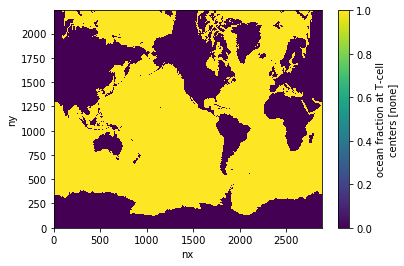

In [210]:
# load the grid
mask = xr.open_dataset('../data/raw/grid_configs/xiao_0125/ocean_mask.nc')['mask']
mask.plot()

# hack to reconstruct the tracer cell positions (this could/should be refined with the actual output of a model run?)
hgrid = xr.open_dataset('../data/raw/grid_configs/xiao_0125/ocean_hgrid.nc')
geolon_t = hgrid.x.isel(nxp=slice(1,-1,2),
                        nyp=slice(1,-1,2)).rename({'nxp':'nx',
                                                   'nyp':'ny'}).transpose(*mask.dims)
geolat_t = hgrid.y.isel(nxp=slice(1,-1,2),
                        nyp=slice(1,-1,2)).rename({'nxp':'nx',
                                                   'nyp':'ny'}).transpose(*mask.dims)

#substitute as coords
mask.coords['geolat_t']=geolat_t
mask.coords['geolon_t']=geolon_t

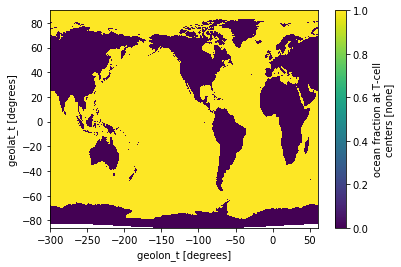

In [211]:
mask.plot(x='geolon_t', y='geolat_t')

In [212]:
rivers_cut = rivers.iloc[0:500]
rivers_cut

,basinid,basinname,A,land_fr,basincellcnt,mouth_lon,mouth_lat,continent,ocean,sea,...,LDON_CONC,SLDON_CONC,SRDON_CONC,PO4_CONC,LDOP_CONC,SLDOP_CONC,SRDOP_CONC,NDET_CONC,PDET_CONC,rspread
0,1,Amazon,"\t5,846,870.0",0.9888,1916,-51.75,-1.25,South America,Atlantic Ocean,Atlantic Ocean,...,0.005960,0.006954,0.006954,5.683052e-04,1.454661e-04,1.697104e-04,1.697104e-04,0.0,0.0,3
1,2,Nile,"\t3,821,590.0",0.9737,1283,31.25,31.25,Africa,Mediterranean+Black Sea,Mediterranean Sea,...,0.000028,0.000032,0.000032,8.259355e-07,6.514683e-07,7.600463e-07,7.600463e-07,0.0,0.0,3
2,3,Zaire,"\t3,694,430.0",0.9802,1203,12.75,-5.75,Africa,Atlantic Ocean,Atlantic Ocean,...,0.006331,0.007386,0.007386,2.099443e-04,1.532297e-04,1.787680e-04,1.787680e-04,0.0,0.0,3
3,4,Mississippi,"\t3,199,170.0",0.9975,1371,-90.25,29.75,North America,Atlantic Ocean,Gulf of Mexico,...,0.007178,0.008375,0.008375,1.426292e-03,1.818420e-04,2.121490e-04,2.121490e-04,0.0,0.0,3
4,5,Ob,"\t3,022,320.0",0.9958,1786,-290.75,66.75,North Asia,Arctic Ocean,Kara Sea,...,0.007252,0.008461,0.008461,1.163505e-03,1.669431e-04,1.947669e-04,1.947669e-04,0.0,0.0,3
5,6,Parana,"\t2,660,890.0",0.9961,939,-58.75,-34.25,South America,Atlantic Ocean,Atlantic Ocean,...,0.007342,0.008566,0.008566,3.633966e-04,1.773194e-04,2.068726e-04,2.068726e-04,0.0,0.0,3
6,7,Yenisei,"\t2,575,660.0",0.9836,1627,-277.75,71.25,North Asia,Arctic Ocean,Kara Sea,...,0.006499,0.007582,0.007582,8.828285e-05,1.560624e-04,1.820728e-04,1.820728e-04,0.0,0.0,3
7,8,Lena,"\t2,438,900.0",0.9981,1651,-232.75,73.25,North Asia,Arctic Ocean,Laptev Sea,...,0.006406,0.007473,0.007473,2.367306e-04,1.547606e-04,1.805540e-04,1.805540e-04,0.0,0.0,3
8,9,Niger,"\t2,237,360.0",0.9963,749,6.75,4.75,Africa,Atlantic Ocean,Atlantic Ocean,...,0.006818,0.007954,0.007954,1.846441e-04,1.677541e-04,1.957131e-04,1.957131e-04,0.0,0.0,3
9,10,Tamanrasett,"\t1,816,640.0",0.9982,651,-16.25,20.25,Africa,Atlantic Ocean,Atlantic Ocean,...,0.006053,0.007061,0.007061,1.350560e-02,4.061052e-05,4.737894e-05,4.737894e-05,0.0,0.0,3


In [213]:
river_conc = make_bgc_river_input(rivers, # for now only with the 
                                  ['LDON_CONC'],
                                  geolon_t.data,
                                  geolat_t.data,
                                  mask.data,
                                  prox=700.)

river mouth at (lon,lat) = (14.250000,12.250000) 
is too far from the ocean and cannot not used.
It can be out of the domain (regional case) or flowing into
an unresolved lake or sea. If you know that river should be
there, you may need to increase the proximity range (prox)
river mouth at (lon,lat) = (48.250000,46.250000) 
is too far from the ocean and cannot not used.
It can be out of the domain (regional case) or flowing into
an unresolved lake or sea. If you know that river should be
there, you may need to increase the proximity range (prox)
river mouth at (lon,lat) = (-273.750000,41.250000) 
is too far from the ocean and cannot not used.
It can be out of the domain (regional case) or flowing into
an unresolved lake or sea. If you know that river should be
there, you may need to increase the proximity range (prox)
river mouth at (lon,lat) = (-242.250000,49.250000) 
is too far from the ocean and cannot not used.
It can be out of the domain (regional case) or flowing into
an unresolv

MemoryError: 

In [ ]:
river_conc.LDON_CONC

In [ ]:
aa = river_conc.LDON_CONC
# aa = aa.where(aa>0)
# aa = aa.interpolate_na(dim='y').interpolate_na(dim='x')

plt.figure(figsize=[16,9])
xr.ufuncs.log10(aa).plot(x='lon', y='lat')
mask.plot.contour(levels=[0.1], colors='k', x='geolon_t', y='geolat_t')
plt.gca().set_ylim(20, 40)
plt.gca().set_xlim(-10, 40)

## check total nutrient input for both cases

In [ ]:
river_conc_clean = river_conc.copy() # Not sure why there are inf values...
river_conc_clean = river_conc_clean.where(xr.ufuncs.isfinite(river_conc_clean)).fillna(0)
xr.ufuncs.isfinite(river_conc_clean.LDON_CONC).all()

In [ ]:
for var in ['LDON_CONC']: # for now just one check
    total_05 = (runoff_05.runoff * area_05 * news_nutrients_05[var].squeeze()).sum(['grid_x_T', 'grid_y_T'])
    total_0125 = (runoff_0125.runoff * runoff_0125.area * river_conc_clean[var].rename({'x':'i', 'y':'j'})).sum(['i', 'j'])
    
    plt.figure()
    plt.title(var)
    plt.plot(total_0125.data)
    plt.plot(total_05.data)
    plt.axhline((rivers['Discharge'] * rivers['LDON_CONC']).sum()*1000, color='k') 
    # I think there is a unit mismatch...does mom6 need kg/s for runoff?
    plt.legend(['high_res', 'low_res'])

## Reproducing Example for regrid_runoff.py (deprecated)
That doesnt work because the files in the ftp are not available anymore....
Soooo Ill try to check other things...
Is the problem that the original data is on a -180/180 grid?

In [82]:
import urllib.request
import os.path
import numpy
import netCDF4

In [83]:
def fetch_file_from_web(url, filename=None, force_download=False):
    """Download file from url and optionally names it as filename"""
    if filename is None: local_file = os.path.split(url)[-1]
    else: local_file = filename
    if not os.path.isfile(local_file) or force_download:
        print('Downloading file %s ...'%local_file)
        urllib.request.urlretrieve(url, local_file)
        print(' ...done.')

In [87]:
fetch_file_from_web('http://data1.gfdl.noaa.gov/~nnz/mom4/COREv2/data_IAF/CORRECTED/calendar_years/runoff.daitren.clim.10FEB2011.nc',
                   filename='../data/raw/input_data/river_runoff_example.nc')
fetch_file_from_web('ftp://ftp.gfdl.noaa.gov/perm/Alistair.Adcroft/MOM6-testing/OM4_05/ocean_hgrid.nc',
                    filename='../data/raw/grid_configs/OM_05/ocean_hgrid.nc')
fetch_file_from_web('ftp://ftp.gfdl.noaa.gov/perm/Alistair.Adcroft/MOM6-testing/OM4_05/ocean_static.nc',
                    filename='../data/raw/grid_configs/OM_05/ocean_static.nc')

In [41]:
inputfile_test = '../data/raw/input_data/river_runoff_example.nc'
outfile_test = '../data/processed/test_reproduce.nc'

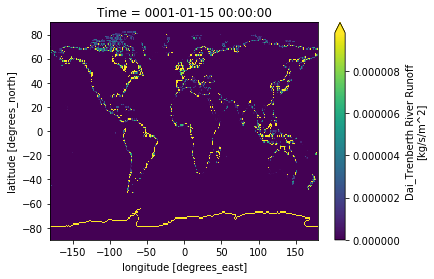

In [10]:
xr.open_dataset(inputfile_test).runoff.isel(Time=0).plot(robust=True)  #.sel(ni=slice(-100,-60), nj=slice(0,50))

In [34]:
!{regrid_script} {hgridpath} {maskpath} -p -m mask -r runoff {inputfile_test} {outfile_test}

/usr/bin/sh: {regrid_script}: command not found


<xarray.Dataset>
Dimensions:   (IQ: 2881, JQ: 2241, i: 2880, j: 2240, time: 12)
Coordinates:
  * i         (i) float32 6.5 7.5 8.5 9.5 10.5 11.5 ... 0.5 1.5 2.5 3.5 4.5 5.5
  * j         (j) float32 6.5 7.5 8.5 9.5 10.5 11.5 ... 0.0 1.0 2.0 3.0 4.0 5.0
  * IQ        (IQ) float32 6.0 7.0 8.0 9.0 10.0 11.0 ... 0.0 1.0 2.0 3.0 4.0 5.0
  * JQ        (JQ) float32 6.0 7.0 8.0 9.0 ... -298.28293 -298.16638 -298.0498
  * time      (time) object -5883517-02-27 00:00:00 ... -5883517-02-27 00:00:00
    lon       (j, i) float32 ...
    lat       (j, i) float32 ...
Data variables:
    lon_crnr  (JQ, IQ) float32 ...
    lat_crnr  (JQ, IQ) float32 ...
    area      (j, i) float64 ...
    runoff    (time, j, i) float32 ...
Attributes:
    title:            Dai_Trenberth Continental Freshwater Discharge
    reference1:       Dai, A., and K. E. Trenberth, 2002: Estimates of freshw...
    reference2:       Dai, A., T. Qian, K. E. Trenberth, and J. D Milliman, 2...
    time_dependence:  Monthly climatolog

ValueError: The input coordinate is not sorted in increasing order along axis 0. This can lead to unexpected results. Consider calling the `sortby` method on the input DataArray. To plot data with categorical axes, consider using the `heatmap` function from the `seaborn` statistical plotting library.

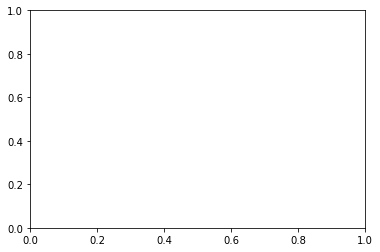

In [51]:
out = xr.open_dataset(outfile_test)
print(out)
plt.figure()
out.area.plot()

# plt.figure()
# out.runoff.max('time').fillna(0).plot(vmax=1e-9)

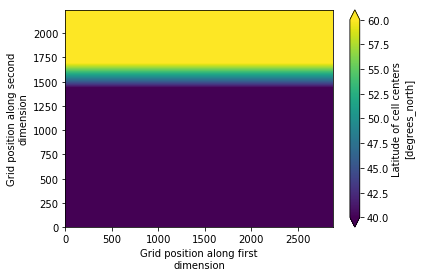

In [61]:
out.sortby(['i', 'j']).lat.plot(vmin=40, vmax=60)

In [ ]:
test_runoff

## Original

In [ ]:
test_runoff = xr.open_dataset(inputfile_test)
test_runoff = shift_lon(test_runoff, 'ni').isel(Time=4).squeeze()
test_runoff.sel(ni=slice(280, 310), nj=slice(40,60)).runoff.plot(vmax=1e-9)

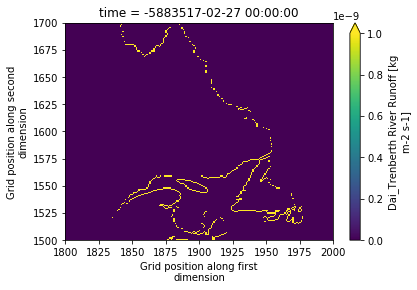

In [65]:
test_runoff_new = xr.open_dataset(outfile_test).sortby(['i', 'j'])
test_runoff_new.isel(i = slice(1800, 2000), j=slice(1500, 1700), time=0).runoff.fillna(0).plot(vmax=1e-9)
# test_runoff.sel(ni=slice(280, 310), nj=slice(40,60)).runoff.plot(vmax=1e-9)